## Data visualisation

### Objectives:
* Business requirement - 1:<br>"The client is interested in having a capability to differentiate visually 'healthy', 'bleached' and 'dead' corals"

### Inputs:
* inputs/corals-dataset/Dataset/test
* inputs/corals-dataset/Dataset/train
* inputs/corals-dataset/Dataset/validation


### Outputs:
# !!!Cell to be revised!!!
* Image shape embeddings pickle file.
* Mean and variability of images per label plot.
* Plot to distinguish the contrast between parasite-contained and uninfected cell images.
* Generate code that answers business requirement 1 and can be used to build an image montage on the Streamlit dashboard.

---

## Set data directory

#### Importing libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("white")
from matplotlib.image import imread

#### Set working directory

In [2]:
cwd= os.getcwd()
os.chdir('/workspace/corals_health')
print("You new current directory is set")
work_dir = os.getcwd()
work_dir

You new current directory is set


'/workspace/corals_health'

#### Define pathes for 'test', 'train' and 'validation' data folders 

In [3]:
my_data_dir = 'inputs/corals-dataset/Dataset'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'
print(train_path)
print(val_path)
print(test_path)

inputs/corals-dataset/Dataset/train
inputs/corals-dataset/Dataset/validation
inputs/corals-dataset/Dataset/test


### Set output directory

In [4]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


##### Set lable names

In [5]:
print(train_path)
labels = os.listdir(train_path)
print('Label for the images are', labels)

inputs/corals-dataset/Dataset/train
Label for the images are ['Bleached', 'Dead', 'Healthy']


### Visualisation of image data

##### Average image size in the 'train' set

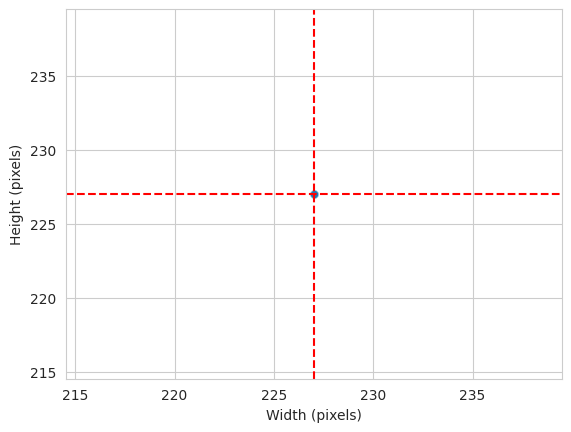

Width average: 227 
Height average: 227
You have 2 graiscale images in your train dataset


In [6]:
dim1, dim2 = [], []
grayscales = 0
for label in labels:
    for image_filename in os.listdir(train_path + '/' + label):
        img = imread(train_path + '/' + label + '/' + image_filename)
        if len(img.shape) == 3:
            d1, d2, colors = img.shape
        elif len(img.shape) == 2: # The image is graiscale
            d1, d2 = img.shape
            grayscales += 1            
            colors = 1
        else:
            raise ValueError('Unexpected image shape!')
        dim1.append(d1)  # image height
        dim2.append(d2)  # image width

sns.set_style("whitegrid")
fig, axes = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())
axes.axvline(x=dim1_mean, color='r', linestyle='--')
axes.axhline(y=dim2_mean, color='r', linestyle='--')
plt.show()
print(f"Width average: {dim2_mean} \nHeight average: {dim1_mean}")
print(f"You have {grayscales} graiscale images in your train dataset")

In [7]:
image_shape = (dim1_mean, dim2_mean, 3)
image_shape

(227, 227, 3)

#### Saving the image shape embeddings

In [8]:
joblib.dump(value=image_shape ,
            filename=f"{file_path}/image_shape.pkl")

['outputs/v1/image_shape.pkl']

In [9]:
print(os.listdir(my_data_dir))

['test', 'train', 'validation']


In [10]:
from tensorflow.keras.preprocessing import image


def load_image_as_array(my_data_dir, new_size=(50, 50), n_images_per_label=20):
    # Function to load images in an array (tensor)
    x, y = np.array([], dtype='int'), np.array([], dtype=object)
    labels = os.listdir(my_data_dir)

    for label in labels:
        counter = 0
        for image_filename in os.listdir(my_data_dir + '/' + label):
            # n_images_per_label: we set a limit, since it may take too much time
            if counter < n_images_per_label:

                img = image.load_img(
                    my_data_dir + '/' + label + '/' + image_filename, target_size=new_size)
                if image.img_to_array(img).max() > 1:
                    img_resized = image.img_to_array(img) / 255
                else:
                    img_resized = image.img_to_array(img)

                x = np.append(x, img_resized).reshape(-1,
                                                      new_size[0], new_size[1], img_resized.shape[2])
                y = np.append(y, label)
                counter += 1

    return x, y

### Load image shapes and labels in an array

In [ ]:
x, y = load_image_as_array(my_data_dir=train_path,
                           new_size=image_shape,
                           n_images_per_label=30)
print(x.shape, y.shape)

#### Plot and save mean and variability of images per label

In [13]:
def plot_mean_variability_per_labels(X, y, figsize=(12,5), save_image=False):
  """
   The pseudo code for the function is:
  * Loop in all labels
  * Subset an array for given label
  * Calculate mean and standard deviation
  * Create a figure displaying mean and variability of images
  * Save image

  """

  for label_to_display in np.unique(y):
    sns.set_style("white")

    y = y.reshape(-1,1,1)
    boolean_mask = np.any(y==label_to_display,axis=1).reshape(-1)
    arr = x[boolean_mask]

    avg_img = np.mean(arr, axis = 0)
    std_img = np.std(arr, axis = 0)
    print(f"==== Label {label_to_display} ====")
    print(f"Image Shape: {avg_img.shape}")
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    axes[0].set_title(f"Average Image for label {label_to_display}")
    axes[0].imshow(avg_img, cmap='gray')
    axes[1].set_title(f"Variability image for label {label_to_display}")
    axes[1].imshow(std_img, cmap='gray')

    if save_image:
      plt.savefig(f"{file_path}/avg_var_{label_to_display}.png", bbox_inches='tight', dpi=150)
    else:
      plt.tight_layout()
      plt.show()
      print("\n")

==== Label Bleached ====
Image Shape: (227, 227, 3)
==== Label Dead ====
Image Shape: (227, 227, 3)
==== Label Healthy ====
Image Shape: (227, 227, 3)


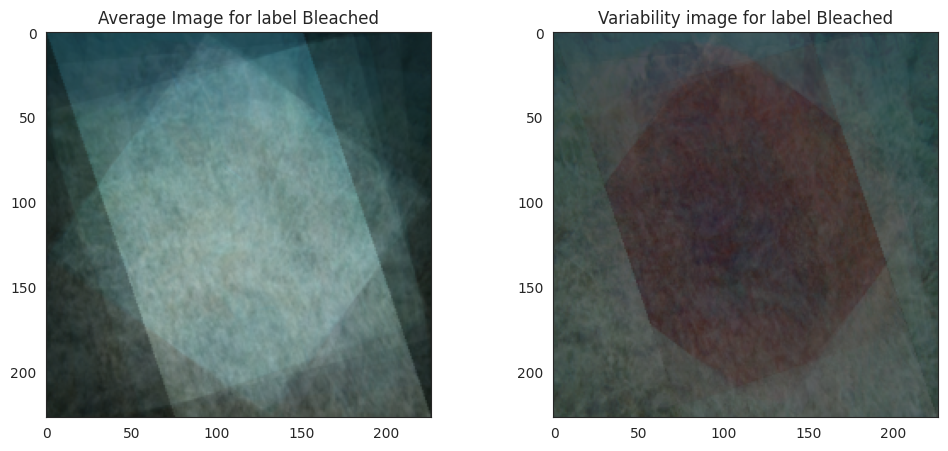

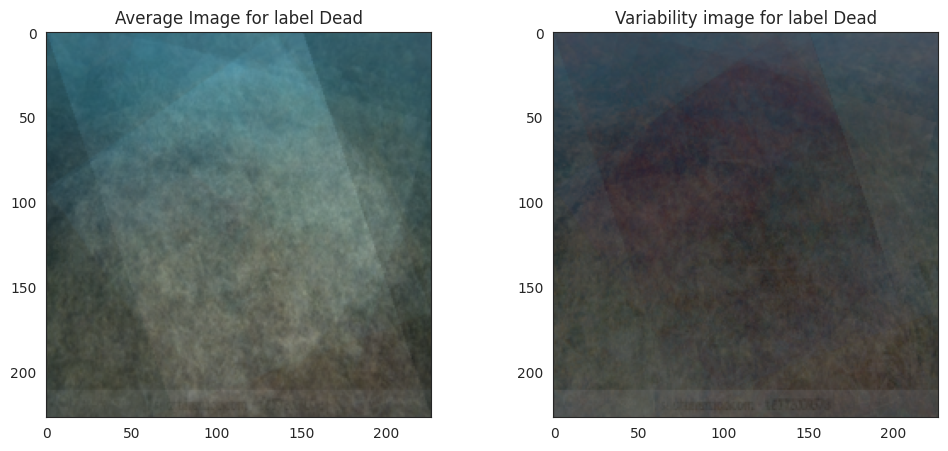

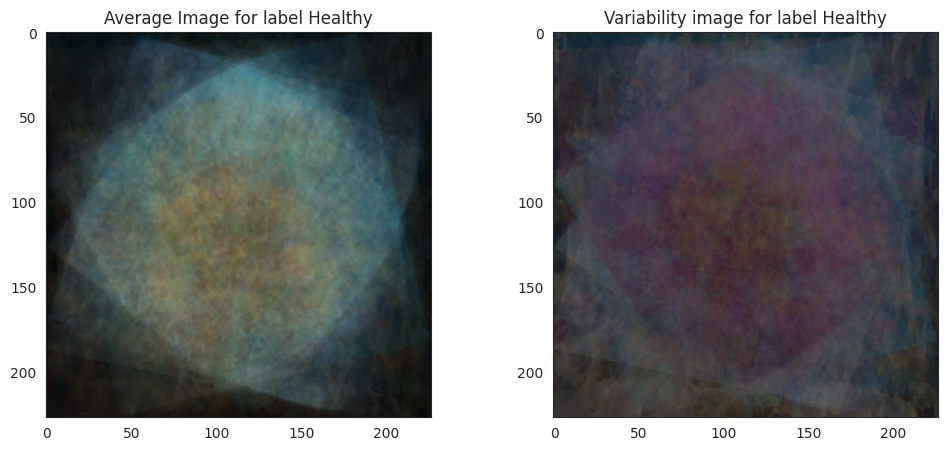

In [15]:
plot_mean_variability_per_labels(X=x, y=y, figsize=(12,5),save_image=True)

#### Difference between _'Healthy' and 'Dead'_, _'Healthy' and 'Bleached'_, and _'Bleached' and 'Dead'_ corals